In [1]:
# load
import scipy.io as sio
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
import matplotlib.pyplot as plt
from fitting_models import fit_sigmoid
import tqdm

np.random.seed(2022)

juiceAmounts = [0.1, 0.3, 1.2, 2.5, 5, 10, 20];
dat = sio.loadmat('measured_neurons/dat_eachneuron.mat')
dat = dat['dat']

num_sim = int(5e3)
initial_guess = [1, 1, 0]

In [2]:
ps = np.zeros((40, num_sim, 3))
for i in tqdm.trange(40):
    dats = dat[0,i][0]
    datas_x = []
    datas_y = []

    for count, j in enumerate(juiceAmounts):
        y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
        x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
        datas_x.extend(x_to_extend)
        datas_y.extend(y_to_extend)

    x = np.array(datas_x)
    y = np.array(datas_y)
    
    for simi in range(num_sim):
        i_sample = np.random.choice(np.linspace(0,len(x)-1,len(x),dtype=np.int16),len(x))
        x_ = x[i_sample]
        y_ = y[i_sample]

        # pars, pcov = curve_fit(func, x_, y_, p0=initial_guess, bounds = (0,np.inf), maxfev = int(1e4))
        pars, lik = fit_sigmoid(x_, y_, x_init=initial_guess)

        ps[i,simi,:] = np.array(pars)
        #print('neuron {} simulation {}'.format(i, simi))
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:39<00:00,  6.99s/it]


In [3]:
sio.savemat('curve_fit_bootstrap.mat', {'ps':ps}) # post fix '_new' to prevent overwriting

In [4]:
# sampling even the neurons 2020 10 25
ps = np.zeros((40, num_sim, 3))
for simi in tqdm.trange(num_sim):
    n_sample = np.random.choice(np.linspace(0,39,dtype=np.int16),40) # neuron sample
    for count_n,i in enumerate(n_sample):
        dats = dat[0,i][0]
        datas_x = []
        datas_y = []

        for count, j in enumerate(juiceAmounts):
            y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
            x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
            datas_x.extend(x_to_extend)
            datas_y.extend(y_to_extend)

        x = datas_x
        y = datas_y


        i_sample = np.random.choice(np.linspace(0,len(x)-1,len(x),dtype=np.int16),len(x))
        x_ = np.array(x)[i_sample]
        y_ = np.array(y)[i_sample]

        pars, lik = fit_sigmoid(x_, y_, x_init=initial_guess)

        ps[count_n,simi,:] = np.array(pars)
        #print('neuron {} simulation {}'.format(count_n, simi))



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:55<00:00, 16.91it/s]


In [5]:
sio.savemat('curve_fit_bootstrap_neurons.mat', {'ps':ps}) # post fix '_new' to prevent overwriting

In [6]:
dat_old = sio.loadmat('measured_neurons/curve_fit_bootstrap.mat')
dat = sio.loadmat('curve_fit_bootstrap.mat')

Text(0.5, 0, 'Least-square(old)')

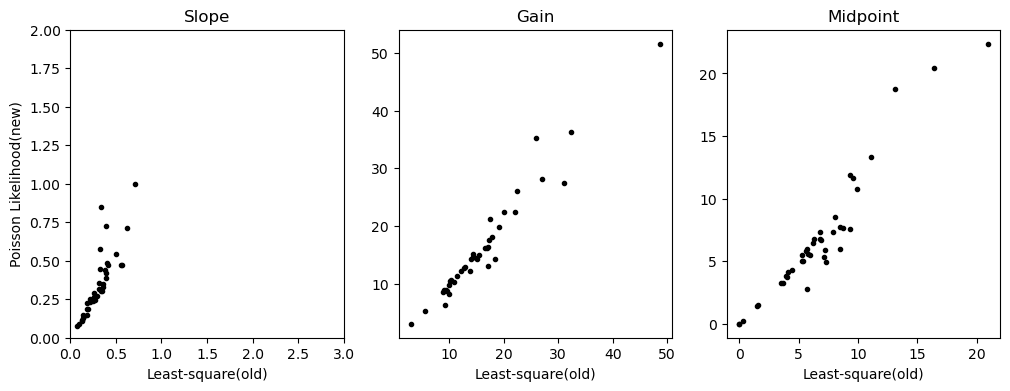

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Slope')
plt.plot(np.median(dat_old['ps'],1)[:,0], np.median(dat['ps'],1)[:,0], 'k.')
plt.ylim([0,2])
plt.xlim([0,3])
plt.ylabel('Poisson Likelihood(new)')
plt.xlabel('Least-square(old)')
plt.subplot(1,3,2)
plt.title('Gain')
plt.plot(np.median(dat_old['ps'],1)[:,1], np.median(dat['ps'],1)[:,1], 'k.')
plt.xlabel('Least-square(old)')
plt.subplot(1,3,3)
plt.title('Midpoint')
plt.plot(np.median(dat_old['ps'],1)[:,2], np.median(dat['ps'],1)[:,2], 'k.')
plt.xlabel('Least-square(old)')